### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import tensorflow as tf
tf.__version__

'2.5.1'

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, RMSPropOptimizer
from pennylane import numpy as np
from pennylane.templates.layers import CVNeuralNetLayers
#import strawberryfields as sf

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [6]:
fano_data = pd.read_csv("../datasets/signal_080_peak_1_fano_adjust.csv")

In [7]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

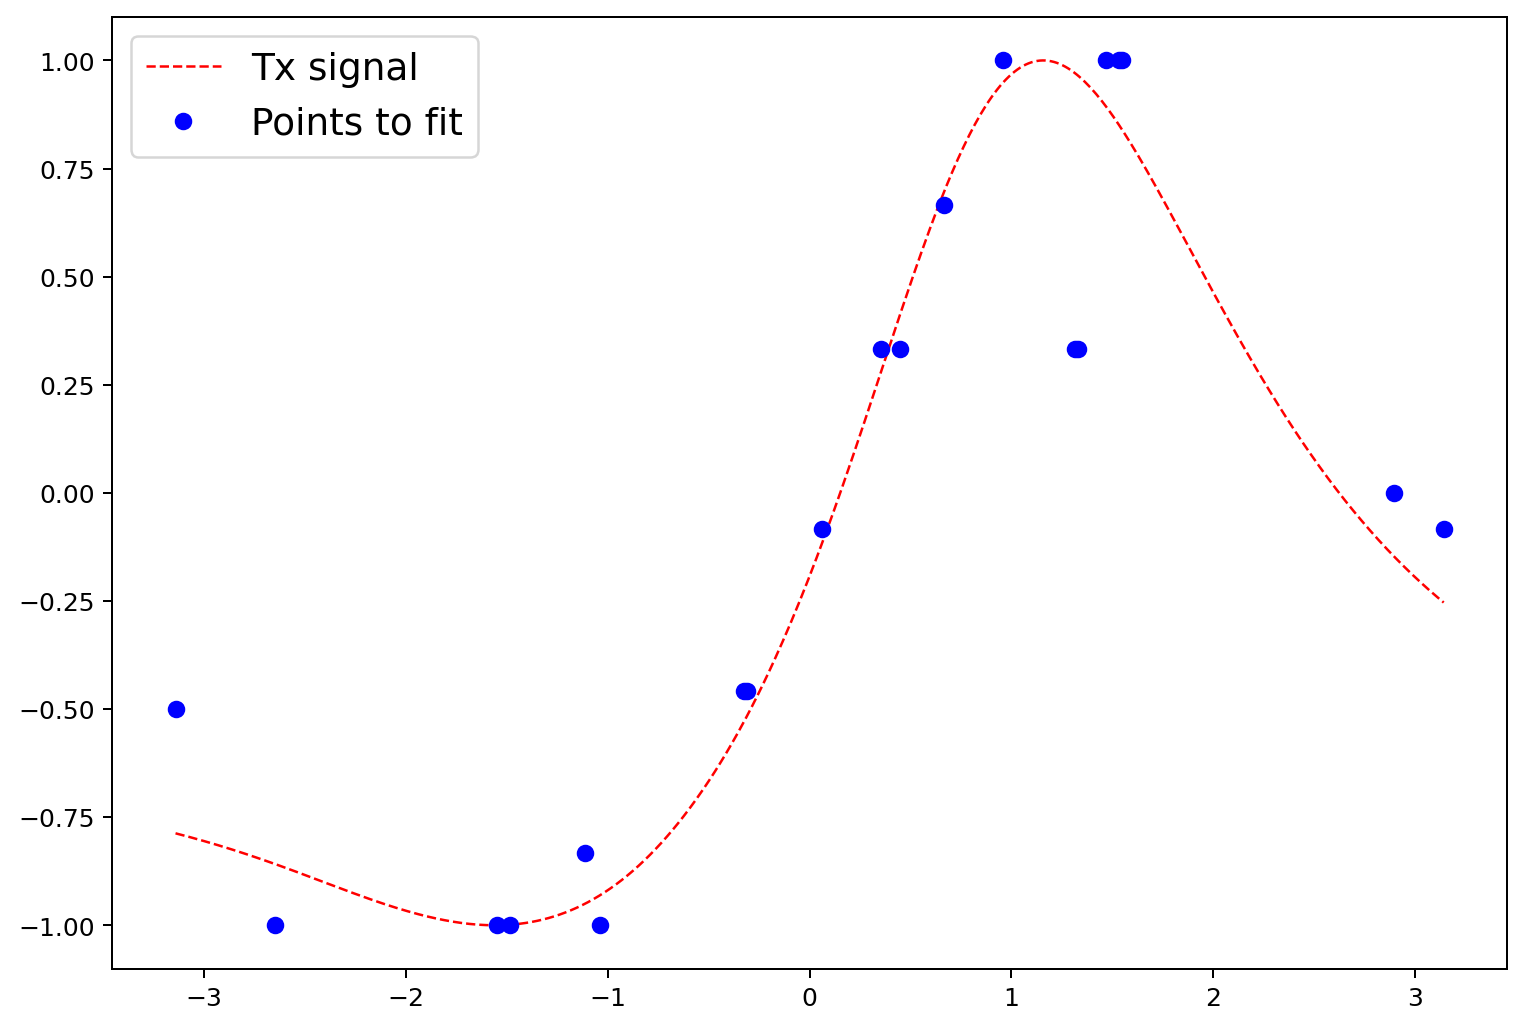

In [9]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [10]:
TOKEN = ""

In [11]:
#import xcc

#settings = xcc.Settings(REFRESH_TOKEN=TOKEN)
#settings.save()

In [12]:
#sf.store_account(TOKEN)

In [13]:
num_qubits = 1

In [14]:
dev = qml.device("strawberryfields.fock", wires=num_qubits, cutoff_dim=10)
#dev = qml.device("strawberryfields.tf", wires=1, cutoff_dim=10)

#dev = qml.device('strawberryfields.remote', backend="X8", shots=10, sf_token=TOKEN)

In [15]:
def layer(v):
    for i in range(num_qubits):
        qml.CVNeuralNetLayers(*v, wires=list(range(num_qubits)))
    
    #qml.Rotation(v[0], wires=0)
    #qml.Squeezing(v[1], 0.0, wires=0)
    #qml.Rotation(v[0], wires=0)
    # Bias
    #qml.Displacement(v[1], 0.0, wires=0)
    # Element-wise nonlinear transformation
    #qml.Kerr(v[1], wires=0) 

In [16]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    
    # Encode input x into quantum state
    for i in range(num_qubits):
        qml.Displacement(x, 0.0, wires=i)

    #for v in var: 
    layer(var)

    return qml.expval(qml.X(0))

In [17]:
def square_loss(labels, predictions):
    
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    
    return loss

In [18]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [19]:
np.random.seed(0)
shapes = CVNeuralNetLayers.shape(n_layers=3, n_wires=num_qubits)
weights = [np.random.random(shape) for shape in shapes]

#print(weights)

In [20]:
X_data = X.numpy()[:, 0]
y_data = y.numpy()[:, 0]

In [21]:
opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = GradientDescentOptimizer(stepsize=0.01)
#opt = RMSPropOptimizer(stepsize=0.01,decay=0.9)

cost_plot = []

var = weights
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.1810859 
Iter:     1 | Cost: 0.1827504 
Iter:     2 | Cost: 0.1371151 
Iter:     3 | Cost: 0.1474881 
Iter:     4 | Cost: 0.1869623 
Iter:     5 | Cost: 0.2117946 
Iter:     6 | Cost: 0.1968799 
Iter:     7 | Cost: 0.1800709 
Iter:     8 | Cost: 0.1765797 
Iter:     9 | Cost: 0.1468871 
Iter:    10 | Cost: 0.1947042 
Iter:    11 | Cost: 0.1423628 
Iter:    12 | Cost: 0.1969157 
Iter:    13 | Cost: 0.1979805 
Iter:    14 | Cost: 0.1446714 
Iter:    15 | Cost: 0.1588546 
Iter:    16 | Cost: 0.2068182 
Iter:    17 | Cost: 0.1408929 
Iter:    18 | Cost: 0.1769758 
Iter:    19 | Cost: 0.2113448 
Iter:    20 | Cost: 0.1419848 
Iter:    21 | Cost: 0.1785420 
Iter:    22 | Cost: 0.1891869 
Iter:    23 | Cost: 0.2338695 
Iter:    24 | Cost: 0.1881692 
Iter:    25 | Cost: 0.2157867 
Iter:    26 | Cost: 0.1410582 
Iter:    27 | Cost: 0.2195874 
Iter:    28 | Cost: 0.1682722 
Iter:    29 | Cost: 0.1679730 
Iter:    30 | Cost: 0.1747531 
Iter:    31 | Cost: 0.1581672 
Iter:   

Iter:   265 | Cost: 0.1786344 
Iter:   266 | Cost: 0.2672955 
Iter:   267 | Cost: 0.1401239 
Iter:   268 | Cost: 0.2103454 
Iter:   269 | Cost: 0.2330343 
Iter:   270 | Cost: 0.1822367 
Iter:   271 | Cost: 0.1667976 
Iter:   272 | Cost: 0.1703465 
Iter:   273 | Cost: 0.1755248 
Iter:   274 | Cost: 0.2200384 
Iter:   275 | Cost: 0.2183592 
Iter:   276 | Cost: 0.1529118 
Iter:   277 | Cost: 0.2346581 
Iter:   278 | Cost: 0.1758820 
Iter:   279 | Cost: 0.1377766 
Iter:   280 | Cost: 0.1364209 
Iter:   281 | Cost: 0.1517725 
Iter:   282 | Cost: 0.1591202 
Iter:   283 | Cost: 0.1916641 
Iter:   284 | Cost: 0.2160081 
Iter:   285 | Cost: 0.1327649 
Iter:   286 | Cost: 0.1984784 
Iter:   287 | Cost: 0.1377768 
Iter:   288 | Cost: 0.1688663 
Iter:   289 | Cost: 0.1869438 
Iter:   290 | Cost: 0.1739275 
Iter:   291 | Cost: 0.1685283 
Iter:   292 | Cost: 0.1695163 
Iter:   293 | Cost: 0.1604577 
Iter:   294 | Cost: 0.2168945 
Iter:   295 | Cost: 0.1617821 
Iter:   296 | Cost: 0.1520462 
Iter:   

In [22]:
for it in range(500):
    var = opt.step(lambda v: cost(v, X_data, y_data), var)
    more_cost = cost(var, X_data, y_data)
    cost_plot.append(more_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, more_cost))
    #if cost(var1, X_data, y_data)<0.1:
    #    opt.update_stepsize(0.005)

Iter:     1 | Cost: 0.1665258 
Iter:     2 | Cost: 0.1813099 
Iter:     3 | Cost: 0.2139157 
Iter:     4 | Cost: 0.1853127 
Iter:     5 | Cost: 0.1938185 
Iter:     6 | Cost: 0.1670958 
Iter:     7 | Cost: 0.1976462 
Iter:     8 | Cost: 0.2656679 
Iter:     9 | Cost: 0.2079230 
Iter:    10 | Cost: 0.1256932 
Iter:    11 | Cost: 0.1667647 
Iter:    12 | Cost: 0.1357490 
Iter:    13 | Cost: 0.1465373 
Iter:    14 | Cost: 0.1529679 
Iter:    15 | Cost: 0.2014730 
Iter:    16 | Cost: 0.1980763 
Iter:    17 | Cost: 0.2148254 
Iter:    18 | Cost: 0.1827173 
Iter:    19 | Cost: 0.1405132 
Iter:    20 | Cost: 0.1330036 
Iter:    21 | Cost: 0.2039746 
Iter:    22 | Cost: 0.1731255 
Iter:    23 | Cost: 0.1406177 
Iter:    24 | Cost: 0.1377307 
Iter:    25 | Cost: 0.1569571 
Iter:    26 | Cost: 0.1835487 
Iter:    27 | Cost: 0.1798714 
Iter:    28 | Cost: 0.1995153 
Iter:    29 | Cost: 0.1593697 
Iter:    30 | Cost: 0.1273979 
Iter:    31 | Cost: 0.1652332 
Iter:    32 | Cost: 0.1963281 
Iter:   

Iter:   267 | Cost: 0.1733934 
Iter:   268 | Cost: 0.1933837 
Iter:   269 | Cost: 0.1281223 
Iter:   270 | Cost: 0.1810926 
Iter:   271 | Cost: 0.1817743 
Iter:   272 | Cost: 0.1515273 
Iter:   273 | Cost: 0.1960841 
Iter:   274 | Cost: 0.1813588 
Iter:   275 | Cost: 0.2030473 
Iter:   276 | Cost: 0.1981862 
Iter:   277 | Cost: 0.1845594 
Iter:   278 | Cost: 0.1655060 
Iter:   279 | Cost: 0.1666424 
Iter:   280 | Cost: 0.1824818 
Iter:   281 | Cost: 0.1870188 
Iter:   282 | Cost: 0.1668684 
Iter:   283 | Cost: 0.2505267 
Iter:   284 | Cost: 0.1892083 
Iter:   285 | Cost: 0.1716967 
Iter:   286 | Cost: 0.2521497 
Iter:   287 | Cost: 0.2038410 
Iter:   288 | Cost: 0.1337152 
Iter:   289 | Cost: 0.1973267 
Iter:   290 | Cost: 0.1444966 
Iter:   291 | Cost: 0.1943000 
Iter:   292 | Cost: 0.2322771 
Iter:   293 | Cost: 0.1460881 
Iter:   294 | Cost: 0.1763036 
Iter:   295 | Cost: 0.2385104 
Iter:   296 | Cost: 0.1632064 
Iter:   297 | Cost: 0.1377114 
Iter:   298 | Cost: 0.1750822 
Iter:   

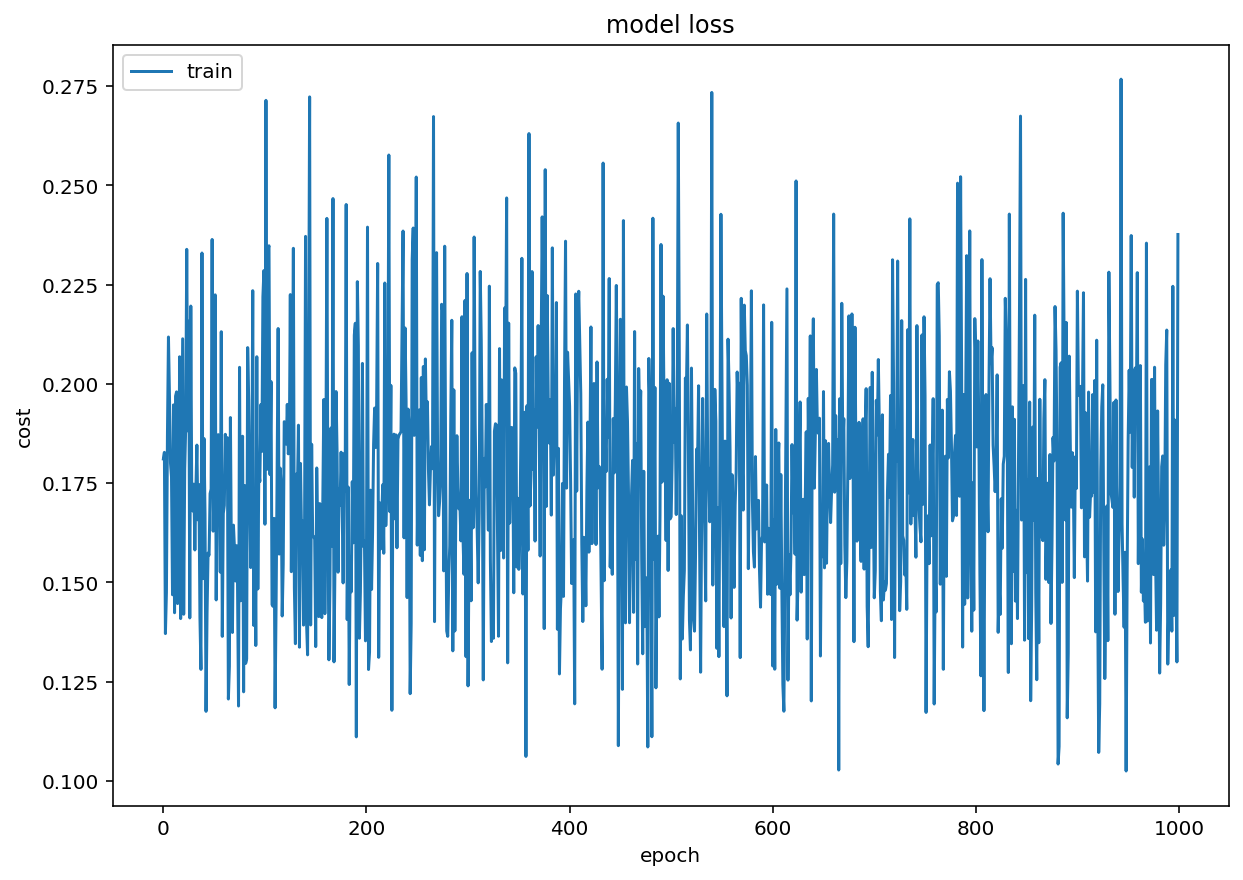

In [23]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [24]:
X_pred = X_.numpy()[:,0]

In [25]:
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

In [26]:
y_predict_smooth = smooth(y_predict)

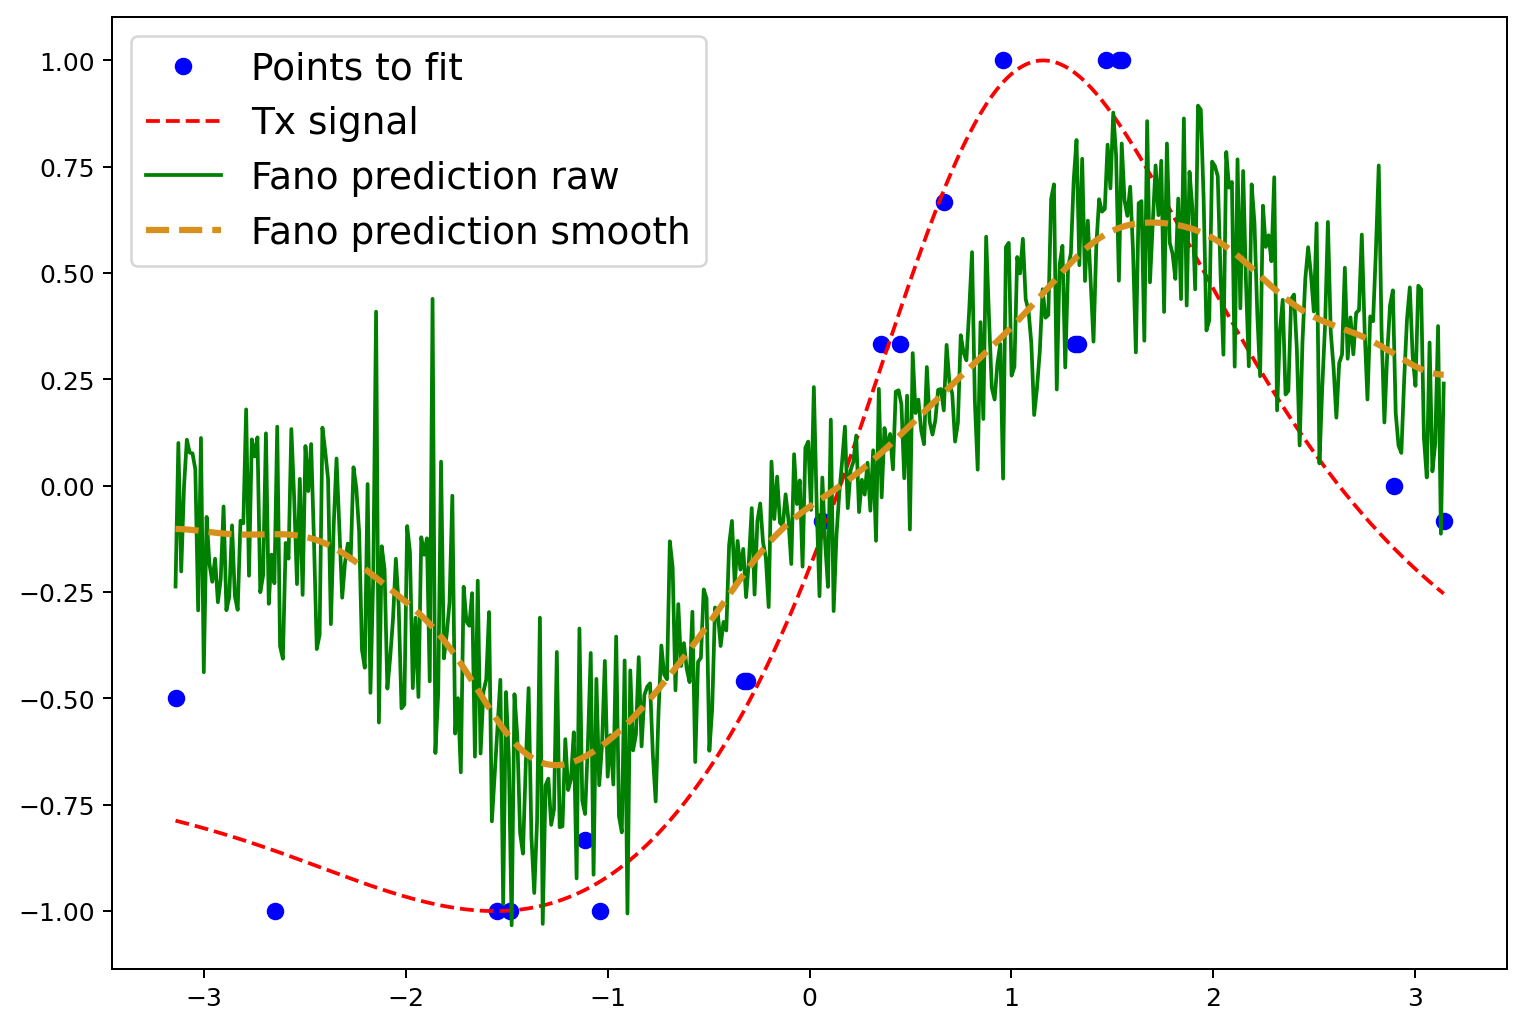

In [27]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [28]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.5085107075


In [29]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright